
# Viral Marketing using NetworkX

Social network platforms like Facebook or Twitter are becoming major sources of information channels. On these new media platforms, everyone acts as both information generator and consumer. In a sense, the spreading of information, or opinions, shares some resemblance with disease spreading. Instead of the disease infecting one person to the next, information is spread from one person to the next. Hence the term 'viral marketing' is used to define the information that goes viral or spreads over social networks, much like an epidemic.


**SIR model in information spreading**

SIR model has been used in disease spreading analysis. However, it can also be used to analyse spreading of information. In the context of Twitter, a particular tweet that originates from a single or a group of Twitter accounts.  The traditional SIR model (in disease spreading) can be mapped onto information spreading as follows:

1. Susceptible - a person has not retweeted the particular tweet.

2. Infected - the person has retweeted it and the retweet remains visible to its followers on Twitter, such that the followers have a chance to retweet it.

3. Removed -  the person has retweeted sometime ago, and the tweet is no longer visible. Thus, this person is not going to retweet the same information again, and none of its followers could retweet.

It is some empirical evidence that the original SIR model in disease spreading, would differ and not behave the real 'spreading' behaviours of people. But for the sake of simplicity, the original SIR model would be utilised here. Similarly, $\beta$ is the probability that a person would spread the tweet/ information to each of its susceptible neighbors. $\alpha$ is the probability that the tweet is no longer visible.


## Problem statement

The maximization of viral spreading through selecting the best set of seed nodes is being explored here. This means what are the best seed nodes to infect/start tweeting in the initialisation round, such that the tweet/information can reach the widest population (with fixed $\beta$ and $\alpha$ values)?  
<br>
Mathematically, if $T$ is defined as the expected number of people who would retweet the information eventually, how do we  select the initial nodes to maximize the value of $T$? To estimate a reliable $T$ value, multiple simulations (Monte Carlo) for each initialization will run to get the average $\langle T\rangle $ value. The initialisation is critical to this problem since it determines the final $\langle T \rangle$ value.


*import libraries*

In [1]:
import networkx as nx 
import numpy as np 

%matplotlib inline 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches 
from __future__ import unicode_literals 
import random 
from tqdm import tqdm 
import sys 
import operator 
from enum import * # used for the states S,I,R

In [2]:
class State(Enum): # define the three states of the nodes.
    Succeptible = 0
    Infected = 1
    Removed = 2

In [3]:
def reset(G):
    """ Initialise/reset all the nodes in the network, before experiment"""
    nx.set_node_attributes(G, State.Succeptible,'state')
        

In [4]:
def initialise_infection_random(G, num_to_infect):
    """Set random selection of nodes to be infected"""
    nodes_to_infect = random.sample(G.nodes(), num_to_infect)
    for n in nodes_to_infect:
        G.nodes[n]['state'] = State.Infected
    return nodes_to_infect

def execute_one_step(G, model):
    """execute the infection model"""
    for n in G:
        model(n, G)

def get_infection_stats(G):
    """Creates lists of nodes in the graph G that are susceptible, infected and removed"""
    infected = []
    succeptible = []
    removed = []
    for n in G:
        if G.nodes[n]['state'] == State.Infected:
            infected.append(n)
        elif G.nodes[n]['state'] == State.Succeptible:
            succeptible.append(n)
        else:
            removed.append(n)
    return succeptible, infected, removed

def print_infection_stats(G):
    """Prints the number of susceptible, infected and removed nodes in graph G."""
    s,i,r = get_infection_stats(G)
    print("Susceptible: %d Infected: %d Removed %d"% (len(s),len(i),len(r)))

def transmission_model_factory(beta=0.03, alpha=0.05):
    """beta: specifies the rate of infection (movement from S to I)
    alpha: specifies the rate of removal (movement from I to R)"""
    def m(n, G):
        if G.nodes[n]['state'] == State.Infected:
            # infect susceptible neighbours with probability pInfect
            for k in G.neighbors(n):
                if G.nodes[k]['state'] == State.Succeptible:
                    if random.random() <= beta:
                        G.nodes[k]['state'] = State.Infected
            if random.random() <= alpha:
                G.nodes[n]['state'] = State.Removed                
    return m

In [5]:
def run_spread_simulation(G, model, initially_infected, run_visualise=False):
    """Runs a single simulation of infection on the graph G, using the specified model"""
    #initially_infected = initialise_infection_degree(G, initial_infection_count)

    s_results = []
    i_results = []
    r_results = []

    dt = 0
    s,i,r = get_infection_stats(G)
    
    pos = nx.spring_layout(G, k=.75)
    
    while len(i) > 0:
        execute_one_step(G, model)
        dt += 1
        s,i,r = get_infection_stats(G)
        s_results.append(len(s))
        i_results.append(len(i))
        r_results.append(len(r))
        sys.stderr.write('\rInfected: %d time step: %d' % (len(i), dt))
        sys.stderr.flush()
        if run_visualise:
            draw_network_to_file(G,pos,dt,initially_infected)
    return s_results, i_results, r_results, dt, initially_infected

def plot_infection(S,I,R,G):
    """Creates a plot of the S,I,R output of a spread simulation"""
    peak_incidence = max(I)
    peak_time = I.index(max(I))
    total_infected = S[0]-S[-1]

    fig_size= [18,13]
    plt.rcParams.update({'font.size': 14, "figure.figsize": fig_size})
    xvalues = range(len(S))
    plt.plot(xvalues, S, color='g', linestyle='-', label="S")
    plt.plot(xvalues, I, color='b', linestyle='-', label="I")
    plt.plot(xvalues, R, color='r', linestyle='-', label="R")
    plt.axhline(peak_incidence, color='b', linestyle='--', label="Peak Indidence")
    plt.annotate(str(peak_incidence),xy=(1,peak_incidence+10), color='b')
    plt.axvline(peak_time, color='b', linestyle=':', label="Peak Time")
    plt.annotate(str(peak_time),xy=(peak_time+1,8), color='b')
    plt.axhline(total_infected, color='r', linestyle='--', label="Total Infected")
    plt.annotate(str(total_infected),xy=(1,total_infected+10), color='r')
    plt.legend()
    plt.xlabel('time step')
    plt.ylabel('Count')
    plt.title('SIR for network size ' + str(G.order()))
    plt.show()
    
def draw_network_to_file(G,pos,t, initially_infected):
    # create the layout
    states = []
    for n in G.nodes():
        if n in initially_infected:
            states.append(3)
        else:
            states.append(G.nodes[n]['state']) 
    from matplotlib import colors
    cmap = colors.ListedColormap(['green', 'blue','red', 'yellow'])
    bounds=[0,1,2,3]

    # draw all the nodes and the edges 
    nx.draw_networkx_nodes(G,pos,cmap=cmap,alpha=0.5,node_size=170, node_color=states)
    nx.draw_networkx_edges(G,pos,alpha=0.075)
    plt.savefig("images/g"+str(t)+".png")
    plt.clf()
    
def plotDistribution(_influences):
    plt.hist(_influences,range=[0,1],bins=30)
    plt.title("Realisations")
    plt.xlabel("Number of infected nodes / Total number of nodes")
    plt.ylabel("Frequency")
    plt.show()

## Setting up experiment

In the first experiments, these parameters are specified:

1. Size of network $N$
2. Initial Network $Gra$
3. The transmission model $m$ that specifies how a node infects others
4. The number of initial seed nodes $ini$ to spread the information (initial infected nodes)

In reality, the value of $ini$ is related to the company budget. A company (with a larger budget) can afford a larger $ini$ to pay more Twitter users (or influencers) to share their commercial on their tweets. 


In [6]:
#Initialise the network
# size of network 
N = 1000 
#create network with specified m value
Gra = nx.barabasi_albert_graph(N, 3) 
m = transmission_model_factory(0.08, 0.5) 
ini = 5 
sampleSize = 20 

## Running first experiment

In the experiment, an initial number of infected nodes were randomly selected and repeated multiple times. At the end of the simulation, the final number of removed nodes $R$ is the number of people who retweeted the same tweet. In the same regard, this is the final popularity of the information $T$. Calculating the average of the $R$ values gives the expected $T$ value we want to maximize.


Infected: 0 time step: 284

The expected influence of the seed nodes is 0.15685


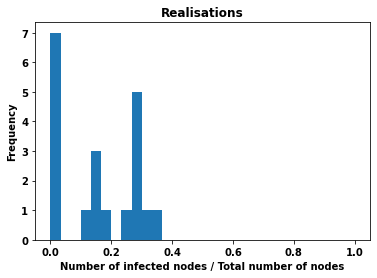

In [7]:
# run Monte Carlo simulations
Influences = []  
for i in range(sampleSize):
    reset(Gra) 
    initially_infected = initialise_infection_random(Gra, ini)
    S, I, R, endtime, ii = run_spread_simulation(Gra, m, initially_infected)
    Influences.append(float(R[-1])/len(Gra))
print('The expected influence of the seed nodes is', np.average(Influences))
plotDistribution(Influences)

From the above plot, there are two peaks (or bimodal spreading behaviour) with one near 0, and one near 0.3. This means the information spread either does not spread at all, or up to about 30% of the whole network once it does. 

## Seeding initial nodes by degree

Rather than selecting initial spreaders (of information) randomly, the following case selects the nodes with the largest (or smallest) degree to start the spreading. 


In [8]:
def initialise_infection_degree(G, num_to_infect, largest=True):
    degrees = G.degree() #get degrees of every node
    #the nodes are sorted in order of degree, highest degree first.
    nodes_to_infect = []
    nodes_sorted_by_degree = sorted(dict(degrees()).items(), key=operator.itemgetter(1), reverse=largest) 
    for x in range(num_to_infect): 
        nodes_to_infect.append(nodes_sorted_by_degree[x])
    for n in nodes_to_infect:
        G.nodes[n[0]]['state'] = State.Infected
    return nodes_to_infect


**Running Monte Carlo simulations using the largest degree nodes as seeds**

Infected: 0 time step: 205

The expected influence of the seed nodes is 0.26070000000000004


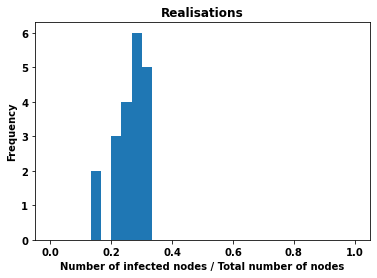

In [9]:
Influences = []  
for i in range(sampleSize):
    reset(Gra) 
    initially_infected = initialise_infection_degree(Gra, ini)
    S, I, R, endtime, ii = run_spread_simulation(Gra, m, initially_infected)
    Influences.append(float(R[-1])/len(Gra))
print('The expected influence of the seed nodes is', np.average(Influences))
plotDistribution(Influences)

From the above plot, the simulation result exhibit the same bimodal behavior as well: either it does not spread out, or spreads out to 30% of the total network eventually. The interesting phenomenon is that the position of the large peak is similar to the first experiment (random initialisation).


**Running Monte Carlo simulations using the smallest degree nodes as seeds**

Infected: 0 time step: 305

The expected influence of the seed nodes is 0.19795


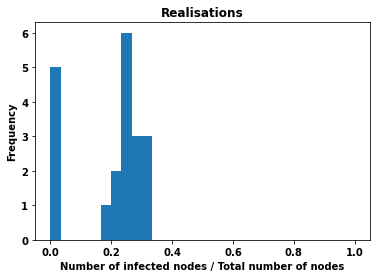

In [10]:
Influences = []  #stores the total number of removed nodes in each run.
for i in range(sampleSize):
    reset(Gra) # initialise all nodes to susceptible
    initially_infected = initialise_infection_degree(Gra, ini, largest = False)
    S, I, R, endtime, ii = run_spread_simulation(Gra, m, initially_infected)
    Influences.append(float(R[-1])/len(Gra))
print('The expected influence of the seed nodes is', np.average(Influences))
plotDistribution(Influences)

From the above plot, the simulation result exhibit the same bimodal behavior as well: either it does not spread out, or spreads out to 30% of the total network eventually. The interesting phenomenon is that the position of the large peak is similar to the first experiment (random initialisation).

## Seeding initial nodes by betweenness centrality

Another experiment is to select the set of nodes with the high betweenness centrality. 'Betweenness' measures the number of shortest paths that a node lies on. In other words, the node (person) most likely to act as a bridge along/between other nodes. 


In [11]:
def initialise_infection_betweenness(G, num_to_infect, largest=True):
    #the nodes are sorted in order of betweenness centrality, highest first.
    nodes_to_infect = []
    bet_cen = nx.betweenness_centrality(G)
    nodes_sorted_by_betweenness = sorted(bet_cen.items(), key=operator.itemgetter(1), reverse=largest)
    for x in range(num_to_infect): 
        nodes_to_infect.append(nodes_sorted_by_betweenness[x])
    for n in nodes_to_infect:
        G.nodes[n[0]]['state'] = State.Infected
    return nodes_to_infect


Infected: 0 time step: 192

The expected influence of the seed nodes is 0.2547


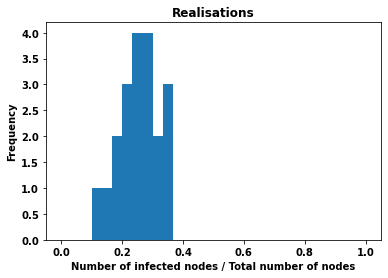

In [12]:
# run Monte Carlo simulations
Influences = []  
for i in range(sampleSize):
    reset(Gra) 
    initially_infected = initialise_infection_betweenness(Gra, ini)
    S, I, R, endtime, ii = run_spread_simulation(Gra, m, initially_infected)
    Influences.append(float(R[-1])/len(Gra))
print('The expected influence of the seed nodes is', np.average(Influences))
plotDistribution(Influences)

From the above plot, the simulation result would exhibit the same bimodal behavior as well: either it does not spread out, or spreads out to 30% of the total network eventually.


## Bimodel behavior and the critical point

The reason behind this bimodal behaviour (in the above simulations), is due to the existence of the so-called 'Giant Component' in the network. Typically, a component is considered 'giant', when the connected set of nodes contains a significant proportion (more than half) of the entire nodes in the network. In other words, the giant component will still hold a significant fraction of the nodes, even if the network expands. This occurs especially in social media; Social networks often start off as having many components, but they grow to form giant components. Thus, the position of that peak is around 0.3 regardless of the initialisation conditions (random, degree, betweenness).


However, the thing is - a tweet needs to go 'viral' to be considered as viral marketing. This 'viral' condition has a clear definition in complex networks, called critical threshold $\gamma_c$. This threshold condition links the information spread within the network topology, where $\gamma = \beta/\alpha$ signifies the spreading strength of the tweet (or information). 
<br>
<br> In the case of Erdos-Renyi networks, $\gamma_c=1/(\langle k \rangle -1)$. The tweet is not considered to be 'viral' if its $\gamma$ value is below the critical value; It has a *CHANCE* to go viral only when $\gamma>\gamma_c$. 



## Below the critical threshold

The created Erdos-Renyi network has average degree 5, thus its critical threshold $\gamma_c=1/(5-1)=0.25$.
<br> The transmission model has $\beta=0.01$ and $\alpha=0.5$, thus $\gamma = 0.01/0.5 = 0.2$. Since $\gamma<\gamma_c$ (i.e., $\gamma$ is smaller than the critical threshold), the spread is not expected to go viral.


In [13]:
#Initialise the network
# size of network 
N = 1000 
# create network with average degree 5.0
Gra = nx.erdos_renyi_graph(N,5.0/N) 
m = transmission_model_factory(0.01, 0.5) 
ini = 5 

Infected: 0 time step: 5

The expected influence of the seed nodes is 0.0055000000000000005


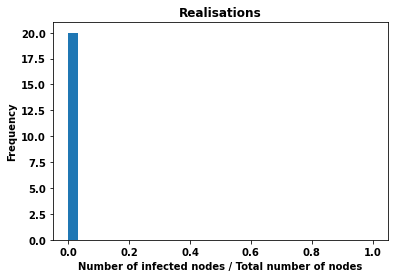

In [14]:
# run Monte Carlo simulations
Influences = []  #stores the total number of removed nodes in each run.
for i in range(sampleSize):
    reset(Gra) # initialise all nodes to susceptible
    initially_infected = initialise_infection_random(Gra, ini)
    S, I, R, endtime, ii = run_spread_simulation(Gra, m, initially_infected)
    Influences.append(float(R[-1])/len(Gra))
print('The expected influence of the seed nodes is', np.average(Influences))
plotDistribution(Influences)

From the above simulation, the information does not spread out (i.e., does not go viral).


## Above the critical threshold

The transmission model parameters are changed to $\beta=0.15$ and $\alpha=0.5$, such that the $\gamma$ value is above the critical threshold. 

In [15]:
#Initialise the network
N = 1000 
Gra = nx.erdos_renyi_graph(N,5.0/N) 
m = transmission_model_factory(0.15, 0.5) 
ini = 5

Infected: 0 time step: 374

The expected influence of the seed nodes is 0.35285


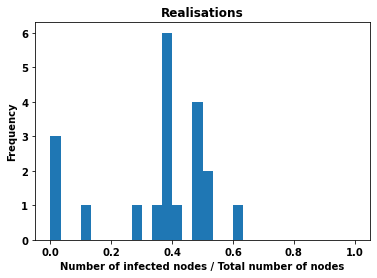

In [16]:
# run Monte Carlo simulations
Influences = []  
for i in range(sampleSize):
    reset(Gra) 
    initially_infected = initialise_infection_random(Gra, ini)
    S, I, R, endtime, ii = run_spread_simulation(Gra, m, initially_infected)
    Influences.append(float(R[-1])/len(Gra))
print('The expected influence of the seed nodes is', np.average(Influences))
plotDistribution(Influences)

From the above plot, it is observed that some of the information (or tweet) will reach a higher/ significant portion of the whole network.

## Conclusion

From the simulations above, it is demonstrated that viral spreading occurs only when the information/tweet reaches a certain threshold level of spreading strength $\gamma$. For any given network structure and model construct (SIR or linear threshold model etc.), there is a well-defined threshold that the information (or disease) can go *VIRAL*. 
<br>
<br> The computational time in the above experiments is also non-negligible, for 1000 nodes and a few thousand links in total. In a real social networks with total number of nodes/accounts in the order of millions, the computational time for a supercomputer would take years for the purpose of finding the best set of seed nodes. 